### Use CV to get HSV values - 2022 0119 CJH
---
* if you don't have it, get it with `pip install opencv-python`
* i added training photos to the training_images folder

In [130]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import pandas as pd

### open and display an image with matplotlib

In [131]:
pwd

'C:\\Cory\\CJH Shared\\Python\\FRC\\FRC_training\\notebooks\\vision'

In [132]:
files = glob.glob('**/*.jpg*', recursive=True)
files

['training_images\\2022_ball_test_1.jpg',
 'training_images\\2022_ball_test_2.jpg',
 'training_images\\2022_ball_test_3.jpg',
 'training_images\\2022_ball_test_4.jpg',
 'training_images\\2022_ball_test_5.jpg',
 'training_images\\2022_ball_test_6.jpg']

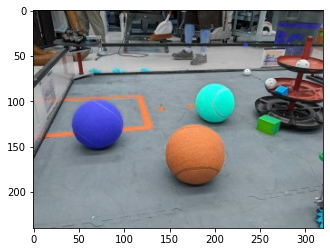

In [133]:
img = cv2.imread(files[0])   # Read the image as BGR
plt.imshow(img)   # Ploting the image using matplotlib

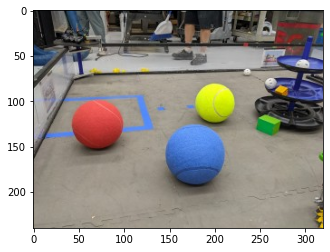

In [134]:
# convert to RGB color convention 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

### RGB components

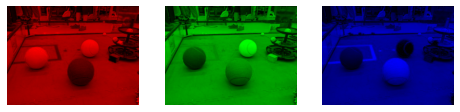

In [135]:
# look at the individual components in RGB space
fix, axs = plt.subplots(ncols=3, nrows=1, figsize=(8,3))
for ix, ax in enumerate(axs):
    temp = np.zeros(img_rgb.shape, dtype='uint8')
    temp[:,:,ix] = img_rgb[:,:,ix]
    ax.imshow(temp)
    ax.set_axis_off()
plt.show()

### HSV components  - note H goes to 180

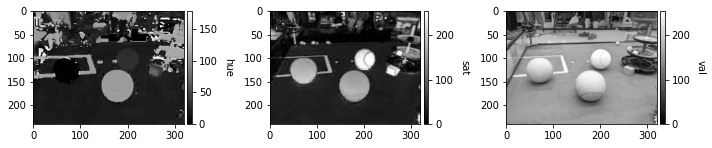

In [136]:
# look at them in HSV space
# look at the individual components in RGB space
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10,4))
divider = [None, None, None]
cax = [None, None, None]
cbar_legend = ['hue', 'sat', 'val']
cmap = 'gray'
for ix, ax in enumerate(axs):
    temp = np.zeros(img_hsv.shape[0:2], dtype='uint8')
    temp[:,:] = img_hsv[:,:,ix]
    im = ax.imshow(temp, cmap=cmap)
    divider[ix] = make_axes_locatable(ax)
    cax[ix] = divider[ix].append_axes("right", size="3%", pad=0.05)
    cb = plt.colorbar(im, cax=cax[ix])
    cb.ax.set_ylabel(cbar_legend[ix], rotation=270, labelpad=15)
    ax.imshow(temp, cmap=cmap)
fig.tight_layout()

### quick examination of the image

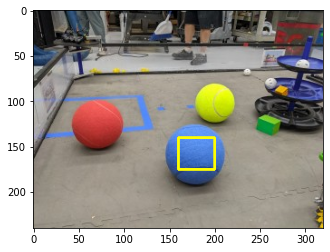

In [199]:
# cv has the origin at top left, and goes over in (x, y)
top_left_x = 160
top_left_y = 140  # x,y of the top left of the rectangle we want
width = 40
height = 35

rectangle_img = img_rgb.copy()
cv2.rectangle(rectangle_img, (top_left_x, top_left_y), (top_left_x+width, top_left_y+height), (255, 255, 0), 2)  # Rectangles: image, top left, bot right, color, thickness
plt.imshow(rectangle_img)

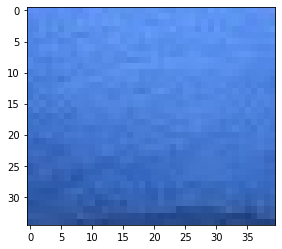

In [201]:
# numpy is not cv - origin is at the top left BUT it goes over in (y, x) 
sub_image_rgb = img_rgb[top_left_y:top_left_y+height, top_left_x:top_left_x+width,:]
sub_image_hsv =  img_hsv[top_left_y:top_left_y+height, top_left_x:top_left_x+width,:]
plt.imshow(sub_image_rgb)

In [202]:
training_data = {'AVG_RED':sub_image_rgb[:,:,0].mean(),
                'AVG_GREEN':sub_image_rgb[:,:,1].mean(),
                'AVG_BLUE':sub_image_rgb[:,:,2].mean(),
                'AVG_HUE':sub_image_hsv[:,:,0].mean(),
                'AVG_SAT':sub_image_hsv[:,:,1].mean(),
                'AVG_VAL':sub_image_hsv[:,:,2].mean(),
                'MAX_HUE':float(np.max(sub_image_hsv[:,:,0])),
                'MIN_HUE':float(np.min(sub_image_hsv[:,:,0])),
                'MAX_SAT':float(np.max(sub_image_hsv[:,:,1])),
                'MIN_SAT':float(np.min(sub_image_hsv[:,:,1])),
                'MAX_VAL':float(np.max(sub_image_hsv[:,:,2])),
                'MIN_VAL':float(np.min(sub_image_hsv[:,:,2]))}
training_data

{'AVG_RED': 71.92285714285714,
 'AVG_GREEN': 122.18071428571429,
 'AVG_BLUE': 210.23142857142858,
 'AVG_HUE': 109.1,
 'AVG_SAT': 168.78214285714284,
 'AVG_VAL': 210.23142857142858,
 'MAX_HUE': 111.0,
 'MIN_HUE': 108.0,
 'MAX_SAT': 200.0,
 'MIN_SAT': 146.0,
 'MAX_VAL': 251.0,
 'MIN_VAL': 124.0}

In [203]:
# trivial example of using pandas to display a table
df = pd.DataFrame([training_data])
pd.set_option("display.precision", 2)
df

,AVG_RED,AVG_GREEN,AVG_BLUE,AVG_HUE,AVG_SAT,AVG_VAL,MAX_HUE,MIN_HUE,MAX_SAT,MIN_SAT,MAX_VAL,MIN_VAL
0,71.92,122.18,210.23,109.1,168.78,210.23,111.0,108.0,200.0,146.0,251.0,124.0


#### see how it worked - not much guesswork anymore!

In [204]:
def hsv_threshold(input, hue, sat, val):
    """Segment an image based on hue, saturation, and value ranges.
    Args:
        input: A BGR numpy.ndarray.
        hue: A list of two numbers the are the min and max hue.
        sat: A list of two numbers the are the min and max saturation.
        lum: A list of two numbers the are the min and max value.
    Returns:
        A black and white numpy.ndarray.
    """
    out = cv2.cvtColor(input, cv2.COLOR_RGB2HSV)
    return cv2.inRange(out, (hue[0], sat[0], val[0]), (hue[1], sat[1], val[1]))

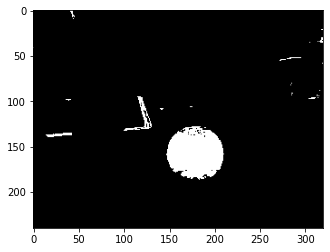

In [205]:
hue_tolerance = 5
h = [training_data['MIN_HUE'] - hue_tolerance, training_data['MAX_HUE'] + hue_tolerance]
s = [training_data['MIN_SAT'], training_data['MAX_SAT']]
v = [training_data['MIN_VAL'], training_data['MAX_VAL']]
hsv_thresh_image = hsv_threshold(img_rgb.copy(), h, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')

#### what if we only do hue?  see that we may pick up more bumpers

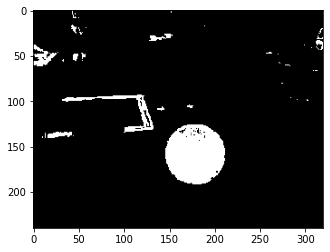

In [206]:
hue_tolerance = 1
h = [training_data['MIN_HUE'] - hue_tolerance, training_data['MAX_HUE'] + hue_tolerance]
s = (50, 250)
v = (50, 250)
hsv_thresh_image = hsv_threshold(img_rgb.copy(), h, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')